# Question 4: Eliminating Residual Connections

In [1]:
import time

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext.data as data
from models.attention import MultiHeadAttention
from models.embedder import Embedder, FeedForward, Norm, PositionalEncoder, get_clones
from transformers import GPT2Tokenizer

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


## Decoder

In [3]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.dropout_1 = nn.Dropout(dropout)
        self.attn_1 = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.ff = FeedForward(d_model, dropout=dropout)
        self.norm_2 = Norm(d_model)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, x, trg_mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn_1(x2, x2, x2, trg_mask))
        x2 = self.norm_2(x)
        x = self.dropout_2(self.ff(x2))  # No residual connection
        return x

In [4]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads, dropout):
        super().__init__()
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model, dropout=dropout)
        self.layers = get_clones(DecoderLayer(d_model, heads, dropout), N)
        self.norm = Norm(d_model)

    def forward(self, trg, trg_mask):
        x = self.embed(trg)
        x = self.pe(x)
        for layer in self.layers:
            x = layer(x, trg_mask)
        return self.norm(x)

## Transformer

In [5]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads, dropout, device):
        super().__init__()
        self.device = device
        self.vocab_size = vocab_size
        self.decoder = Decoder(vocab_size, d_model, N, heads, dropout)
        self.out = nn.Linear(d_model, vocab_size)

    def forward(self, trg, trg_mask):
        d_output = self.decoder(trg, trg_mask)
        output = self.out(d_output)
        return output

## No-Peak Mask

In [6]:
def nopeak_mask(size, device):
    np_mask = ~torch.triu(torch.ones((1, size, size), device=device), diagonal=1).bool()
    return np_mask

## Data Feeder

### Tokenizer

In [7]:
TOKENIZER = GPT2Tokenizer.from_pretrained("gpt2")

In [8]:
TOKENIZER.add_special_tokens(
    {"pad_token": "[PAD]", "bos_token": "<sos>", "eos_token": "<eos>"}
)
TOKENIZER.pad_token_id, TOKENIZER.bos_token_id, TOKENIZER.eos_token_id

(50257, 50258, 50259)

### Tokenization

In [9]:
def load_and_tokenize_file(file_path, tokenizer):
    with open(file_path, "r", encoding="utf-8") as file:
        lines = [line.strip() for line in file if line.strip()]

    # Tokenize each line with special tokens and store tokens
    all_token_ids = []
    for line in lines:
        modified_line = f"<sos> {line} <eos>"  # Add special tokens
        tokens = tokenizer.tokenize(modified_line)
        token_ids = tokenizer.convert_tokens_to_ids(tokens)
        all_token_ids.extend(token_ids)

    return all_token_ids

### Batching and Creating Sequences

In [10]:
class BatchGenerator:
    def __init__(self, data, seq_len=512, batch_size=32, pad_token_id=0):
        self.data = data
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.pad_token_id = pad_token_id
        self.total_data_len = len(data)
        self.steps_per_epoch = (
            self.total_data_len + self.batch_size * self.seq_len - 1
        ) // (self.seq_len * self.batch_size)

    def generate(self):
        start_index = 0
        while True:
            # Calculate the end index of the batch
            end_index = start_index + self.batch_size * self.seq_len
            if end_index > self.total_data_len:
                # Handle end of array with padding if not enough data to complete the batch
                residual_data = self.data[start_index : self.total_data_len]
                padding_needed = end_index - self.total_data_len
                padded_data = np.full(padding_needed, self.pad_token_id, dtype=int)
                batch_data = np.concatenate((residual_data, padded_data))
                start_index = (
                    self.total_data_len
                )  # Set start_index to total_data_len to end generation
            else:
                batch_data = self.data[start_index:end_index]
                start_index += self.batch_size * self.seq_len

            # Reshape batch data to the required dimensions
            batch_data = np.array(batch_data).reshape(self.batch_size, self.seq_len)
            yield batch_data

            if start_index >= self.total_data_len:
                break

## Training

In [11]:
def get_model(vocab_size, d_model=512, N=6, heads=8, dropout=0.1, device="cpu"):
    model = Transformer(vocab_size, d_model, N, heads, dropout, device)
    model.to(device)
    return model

In [12]:
def train_model(
    model, train_generator, valid_generator, optimizer, device, epochs, print_every=50
):
    train_losses = []
    train_perplexities = []
    valid_losses = []
    valid_perplexities = []

    for epoch in range(epochs):
        # Training Phase
        model.train()
        total_train_loss = 0
        intermediate_train_loss = 0
        start = time.time()

        # Adjust to use the generator
        for i, batch in enumerate(train_generator.generate()):
            batch_tensor = torch.tensor(batch).to(device)
            no_peak_mask = nopeak_mask(batch_tensor.size(1), device)

            # https://github.com/SamLynnEvans/Transformer/blob/master/Batch.py#L20
            preds = model(batch_tensor, no_peak_mask)
            preds = preds[:, :-1, :]  # Exclude the last time step predictions
            ys = (
                batch_tensor[:, 1:].contiguous().view(-1)
            )  # Targets shifted by one position

            optimizer.zero_grad()
            loss = F.cross_entropy(
                preds.reshape(-1, preds.size(-1)),
                ys,
                ignore_index=TOKENIZER.pad_token_id,
            )
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            intermediate_train_loss += loss.item()

            if (i + 1) % print_every == 0:
                p = int(100 * (i + 1) / train_generator.steps_per_epoch)
                avg_loss = intermediate_train_loss / print_every
                print(
                    f"{int((time.time() - start) // 60)}m: epoch {epoch + 1} [{p}%] Train loss = {avg_loss:.3f}",
                    end="\r",
                )
                intermediate_train_loss = 0

            if (i + 1) == train_generator.steps_per_epoch:
                break  # Stop after processing all steps per epoch

        avg_train_loss = total_train_loss / train_generator.steps_per_epoch
        train_perplexity = torch.exp(torch.tensor(avg_train_loss)).item()
        train_losses.append(avg_train_loss)
        train_perplexities.append(train_perplexity)

        # Validation Phase
        model.eval()
        total_valid_loss = 0
        with torch.no_grad():
            for i, batch in enumerate(valid_generator.generate()):
                batch_tensor = torch.tensor(batch).to(device)
                no_peak_mask = nopeak_mask(batch_tensor.size(1), device)

                preds = model(batch_tensor, no_peak_mask)
                preds = preds[:, :-1, :]
                ys = batch_tensor[:, 1:].contiguous().view(-1)

                loss = F.cross_entropy(
                    preds.reshape(-1, preds.size(-1)),
                    ys,
                    ignore_index=TOKENIZER.pad_token_id,
                )
                total_valid_loss += loss.item()

                if (i + 1) == valid_generator.steps_per_epoch:
                    break  # Stop after processing all steps per epoch

        avg_valid_loss = total_valid_loss / valid_generator.steps_per_epoch
        valid_perplexity = torch.exp(torch.tensor(avg_valid_loss)).item()
        valid_losses.append(avg_valid_loss)
        valid_perplexities.append(valid_perplexity)

        print(
            f"Epoch {epoch + 1}: Train loss = {avg_train_loss:.3f}, Train Perplexity = {train_perplexity:.3f}"
        )
        print(
            f"Epoch {epoch + 1}: Validation loss = {avg_valid_loss:.3f}, Validation Perplexity = {valid_perplexity:.3f}"
        )

    return train_losses, train_perplexities, valid_losses, valid_perplexities

In [13]:
train_tokens = load_and_tokenize_file("data/wiki2.train.txt", TOKENIZER)
train_batch_generator = BatchGenerator(
    train_tokens, seq_len=512, batch_size=25, pad_token_id=TOKENIZER.pad_token_id
)

valid_tokens = load_and_tokenize_file("data/wiki2.valid.txt", TOKENIZER)
valid_batch_generator = BatchGenerator(
    valid_tokens, seq_len=512, batch_size=25, pad_token_id=TOKENIZER.pad_token_id
)

We're using the same hyperparameters as earlier as they work well.

In [14]:
vocab_size = len(TOKENIZER)
model = get_model(vocab_size, d_model=512, N=6, heads=8, dropout=0.1, device=DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
results = train_model(
    model,
    train_batch_generator,
    valid_batch_generator,
    optimizer,
    DEVICE,
    epochs=10,
    print_every=50,
)

Epoch 1: Train loss = 7.307, Train Perplexity = 1491.374
Epoch 1: Validation loss = 6.677, Validation Perplexity = 793.885
Epoch 2: Train loss = 7.091, Train Perplexity = 1201.209
Epoch 2: Validation loss = 6.723, Validation Perplexity = 831.669
Epoch 3: Train loss = 7.052, Train Perplexity = 1154.836
Epoch 3: Validation loss = 6.826, Validation Perplexity = 921.868
Epoch 4: Train loss = 7.030, Train Perplexity = 1130.410
Epoch 4: Validation loss = 6.765, Validation Perplexity = 866.659
Epoch 5: Train loss = 7.032, Train Perplexity = 1132.258
Epoch 5: Validation loss = 6.729, Validation Perplexity = 836.110
Epoch 6: Train loss = 7.023, Train Perplexity = 1121.613
Epoch 6: Validation loss = 6.741, Validation Perplexity = 846.821
Epoch 7: Train loss = 7.020, Train Perplexity = 1118.246
Epoch 7: Validation loss = 6.729, Validation Perplexity = 836.705
Epoch 8: Train loss = 7.033, Train Perplexity = 1133.285
Epoch 8: Validation loss = 6.715, Validation Perplexity = 824.715
Epoch 9: Train l

```python
Epoch 1: Train loss = 7.307, Train Perplexity = 1491.374
Epoch 1: Validation loss = 6.677, Validation Perplexity = 793.885
Epoch 2: Train loss = 7.091, Train Perplexity = 1201.209
Epoch 2: Validation loss = 6.723, Validation Perplexity = 831.669
Epoch 3: Train loss = 7.052, Train Perplexity = 1154.836
Epoch 3: Validation loss = 6.826, Validation Perplexity = 921.868
Epoch 4: Train loss = 7.030, Train Perplexity = 1130.410
Epoch 4: Validation loss = 6.765, Validation Perplexity = 866.659
Epoch 5: Train loss = 7.032, Train Perplexity = 1132.258
Epoch 5: Validation loss = 6.729, Validation Perplexity = 836.110
Epoch 6: Train loss = 7.023, Train Perplexity = 1121.613
Epoch 6: Validation loss = 6.741, Validation Perplexity = 846.821
Epoch 7: Train loss = 7.020, Train Perplexity = 1118.246
Epoch 7: Validation loss = 6.729, Validation Perplexity = 836.705
Epoch 8: Train loss = 7.033, Train Perplexity = 1133.285
Epoch 8: Validation loss = 6.715, Validation Perplexity = 824.715
Epoch 9: Train loss = 7.046, Train Perplexity = 1148.350
Epoch 9: Validation loss = 6.711, Validation Perplexity = 821.048
Epoch 10: Train loss = 7.053, Train Perplexity = 1155.912
Epoch 10: Validation loss = 6.701, Validation Perplexity = 812.966
```

In [16]:
train_losses, train_perplexities, valid_losses, valid_perplexities = results

### Training Results

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [18]:
epochs = list(range(1, len(train_losses) + 1))
train_data = pd.DataFrame(
    {
        "Epoch": epochs,
        "Train Loss": train_losses,
        "Train Perplexity": train_perplexities,
    }
)

valid_data = pd.DataFrame(
    {
        "Epoch": epochs,
        "Validation Loss": valid_losses,
        "Validation Perplexity": valid_perplexities,
    }
)

/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


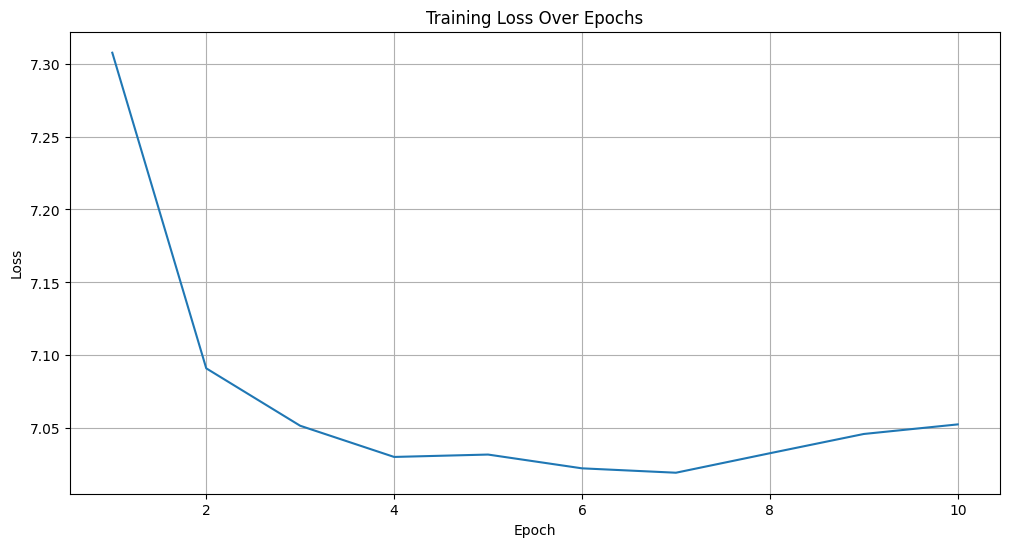

In [19]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=train_data, x="Epoch", y="Train Loss")
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


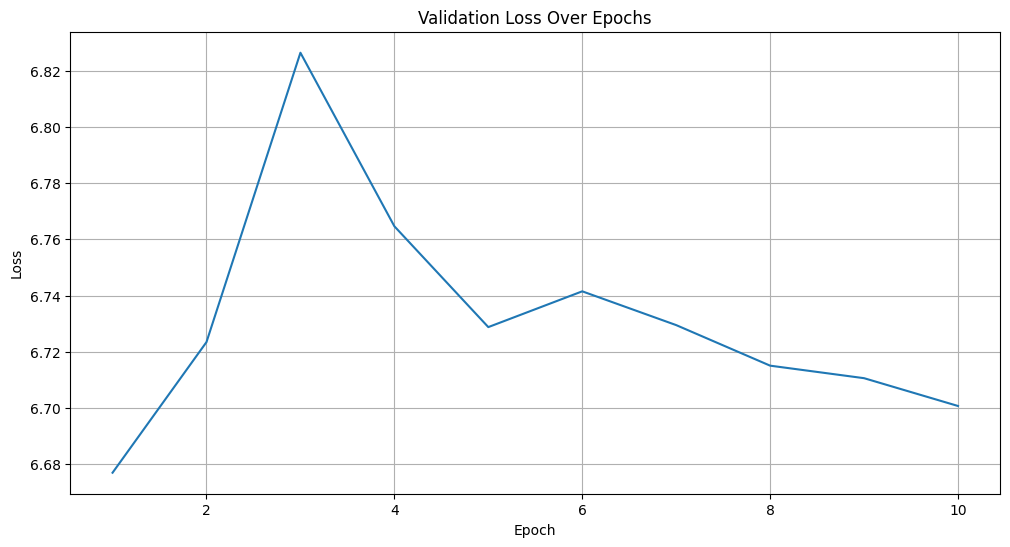

In [20]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=valid_data, x="Epoch", y="Validation Loss")
plt.title("Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


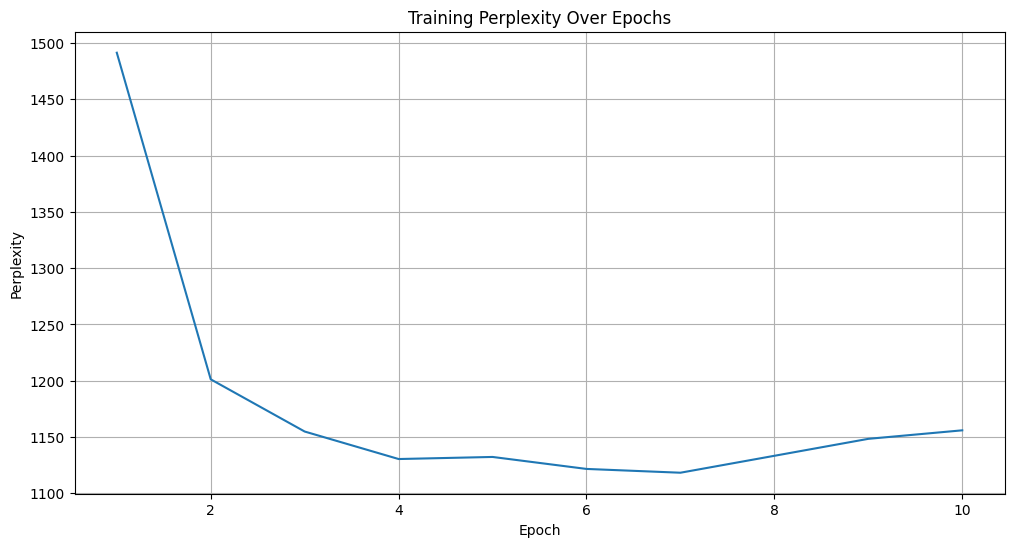

In [21]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=train_data, x="Epoch", y="Train Perplexity")
plt.title("Training Perplexity Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.grid(True)
plt.show()

/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


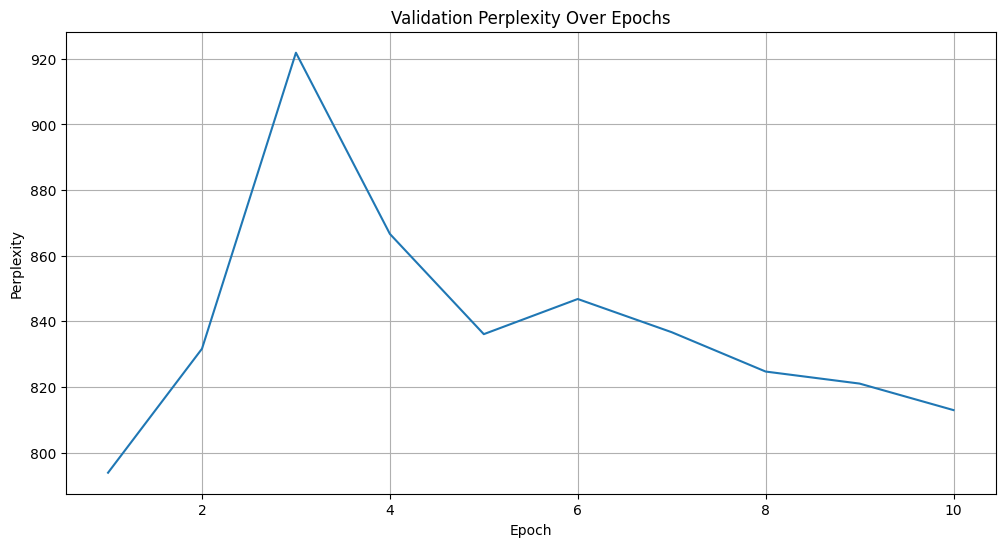

In [22]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=valid_data, x="Epoch", y="Validation Perplexity")
plt.title("Validation Perplexity Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.grid(True)
plt.show()

## Testing

In [23]:
torch.save(model.state_dict(), "model_wgts/model_weights_q4.pth")

In [24]:
saved_model = get_model(
    vocab_size, d_model=512, N=6, heads=8, dropout=0.1, device=DEVICE
)

In [25]:
saved_model.load_state_dict(
    torch.load("model_wgts/model_weights_q4.pth", map_location=DEVICE)
)

<All keys matched successfully>

In [26]:
test_tokens = load_and_tokenize_file("data/wiki2.test.txt", TOKENIZER)
test_batch_generator = BatchGenerator(
    train_tokens, seq_len=512, batch_size=25, pad_token_id=TOKENIZER.pad_token_id
)

In [27]:
def test_model(model, generator, device):
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(generator.generate()):
            batch_tensor = torch.tensor(batch).to(device)
            no_peak_mask = nopeak_mask(batch_tensor.size(1), device)

            preds = model(batch_tensor, no_peak_mask)
            preds = preds[:, :-1, :]
            ys = batch_tensor[:, 1:].contiguous().view(-1)

            loss = F.cross_entropy(
                preds.reshape(-1, preds.size(-1)),
                ys,
                ignore_index=TOKENIZER.pad_token_id,
            )
            total_test_loss += loss.item()

            if (i + 1) == generator.steps_per_epoch:
                break

    avg_test_loss = total_test_loss / generator.steps_per_epoch
    test_perplexity = torch.exp(torch.tensor(avg_test_loss)).item()

    return avg_test_loss, test_perplexity

In [28]:
loss, perplexity = test_model(saved_model, test_batch_generator, DEVICE)

In [29]:
print("Average Loss:", loss)

Average Loss: 7.13412469625473


In [30]:
print("Perplexity:", perplexity)

Perplexity: 1254.0389404296875


* The residual connections allow the gradient to flow directly through the network during backpropagation, mitigating issues related to the vanishing gradient problem.
* This is especially vital in deep networks like Transformers, where multiple layers can lead to gradients becoming too small (vanishing) or too large (exploding) as they propagate back through the network during training.
* This in a way is a regularization effect, help layers learn identity functions, which can be crucial when additional layers do not necessarily add new information.
* Without residual connections, the model must rely entirely on the current layer's transformations to propagate information.
* Which is what's causing our perplexities to be suboptimal.